In [1]:
#!/usr/bin/python

import numpy as np
import math
from astropy.io import fits as fits
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
import pandas as pd
from pandas import DataFrame, Series
from astropy.wcs import WCS as WCS

import import_ipynb
import Pipe3D_Asier_Test as Pipe3D

from mpdaf.obj import hms2deg
from mpdaf.obj import dms2deg

from astropy.convolution import Gaussian2DKernel
from astropy.convolution import convolve

from scipy.stats import ks_2samp
from scipy import stats

importing Jupyter notebook from Pipe3D_Asier_Test.ipynb


In [2]:
#Crear arrays con los datos de todas las galaxias.

Numb_Lines = len(open('Names_Amusing_true.txt').readlines())

All_SN_type = np.zeros(Numb_Lines)
All_Prob_Ha = np.zeros(Numb_Lines)
All_Cumul_Ha = np.zeros(Numb_Lines)
All_Prob_II = np.zeros(Numb_Lines)
All_Cumul_II = np.zeros(Numb_Lines)
All_Prob_Ia = np.zeros(Numb_Lines)
All_Cumul_Ia = np.zeros(Numb_Lines)


SN2006et


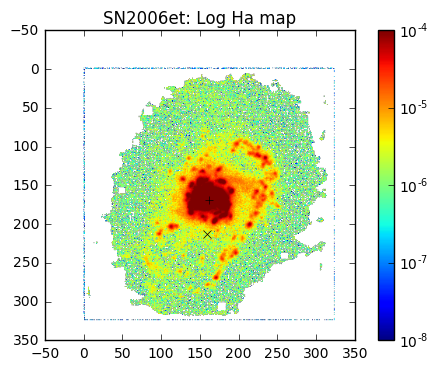

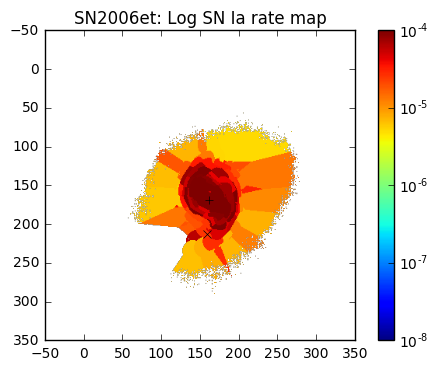

In [3]:
names = open('Names_Amusing_true.txt')   #  Names_Amusing.txt  o   Nombre.txt
Galaxy = -1
nIa = 0
nII = 0
for lines in names:
    line= lines[:-1]
    print(line)
    Galaxy = Galaxy+1

    df = pd.read_csv('Amusing_Table.csv')  # To find the Galaxy data
    Names_1 = df['SN_name']
    Names_2 = df['def_name']
    R = 0

    for names in Names_1:              # Finding the Galaxy in the DataFrame
        R=R+1
        if line == names:
            Row = R-1
    R = 0
    for names in Names_2:              # Some Galaxies have the name in other column
        R=R+1
        if line == names:
            Row = R-1

    # Pixel de la SN
    Pix_X = np.int(df.at[Row,'SNX'] -1)   # Enteros para que no de problemas al medir los mapas.
    Pix_Y = np.int(df.at[Row,'SNY'] -1)
    
    # Pixel del centro de la Galaxia
    Pix_X_GAL = int(df.at[Row,'GALX'] -1)
    Pix_Y_GAL = int(df.at[Row,'GALY'] -1)

    # Supernova type
    if df.at[Row,'SN_type'] == 'Ia':
        SN_TYPE = 1
        nIa = nIa + 1
    elif df.at[Row,'SN_type'] == 'II':
        SN_TYPE = 2
        nII = nII + 1
    else:
        SN_TYPE = 0

    # Call to Pipe3D code
    line = Pipe3D.Pipe3D_galaxy(line)

#~~~~~~~~~~~~~~~~~~ H Alpha ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

    # Read the Ha map of the galaxy
    hdulist = fits.open('Data/Amusing/flux_elines.'+line.name+'.cube.fits')
    line.Ha_Map = hdulist[0].data[20]
    line.Ha_Map_extra = hdulist[0].data[20]  #$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
    
    #$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
    
    # An Array whit all the value of the Ha map
    line.Prob_List_extra = np.ndarray.flatten(line.Ha_Map_extra)
    # The array orther in value
    line.Order_Prob_List_extra = np.sort(line.Prob_List_extra)
    
    # Normalizar
    line.Norm_Ha_extra = 0
    for i in range(len(line.Order_Prob_List_extra)):
        line.Norm_Ha_extra = line.Norm_Ha_extra + line.Order_Prob_List_extra[i]

    line.Ha_Map_extra = line.Ha_Map_extra / line.Norm_Ha_extra
    
    # Pintar Log
    plt.imshow(line.Ha_Map_extra, norm=LogNorm(),vmin=1e-8,vmax=1e-4)
    plt.colorbar()
    plt.title('{}: Log Ha map' .format(line.name))
    plt.plot([Pix_X_GAL],[Pix_Y_GAL],'k+')
    plt.plot([Pix_X],[Pix_Y],'kx')
    plt.savefig(''+line.name+'_Ha_Map_Log_extra.png')
    plt.show()
    plt.close()
    
    #$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
    
    # Gaussian function
    stddev = 7
    gauss = Gaussian2DKernel(stddev)
    
    # Gaussian convolve
    line.Ha_Map = convolve(line.Ha_Map, gauss)
    
    # An Array whit all the value of the Ha map
    line.Prob_List = np.ndarray.flatten(line.Ha_Map)
    # The array orther in value
    line.Order_Prob_List = np.sort(line.Prob_List)

    n, bins, patches = plt.hist(line.Order_Prob_List[line.Order_Prob_List<0.05],100)
    plt.title('std negativa = {}'.format(np.nanstd(line.Prob_List[line.Prob_List<0])))
    plt.axis([-0.01, 0.05, 0, 10000])
    #plt.show()
    plt.close()

    # Pintar Log
    plt.imshow(line.Ha_Map, norm=LogNorm())
    plt.colorbar()
    plt.plot([Pix_X_GAL],[Pix_Y_GAL],'k+')
    plt.plot([Pix_X],[Pix_Y],'kx')
    plt.title('{} Log Ha map Raw'.format(line.name))
    plt.savefig('result/'+line.name+'_Ha_Map_Log_Raw.png')
    #plt.show()
    plt.close()

    # Standard deviation of negative values (indicatve of noise level)
    Sigmas_of_noise = 6
    
    noise_level = Sigmas_of_noise * np.nanstd(line.Prob_List[line.Prob_List<0])
    line.Order_Prob_List[line.Order_Prob_List<noise_level] = 0.
    line.Ha_Map[line.Ha_Map<noise_level] = 0.

    n, bins, patches = plt.hist(line.Order_Prob_List[line.Order_Prob_List<0.05],100)
    plt.title('noise level = {}'.format(noise_level))
    plt.axis([0, 0.05, 0, 100])
    #plt.show()
    plt.close()

    # Normalizar
    line.Norm_Ha = 0
    for i in range(len(line.Order_Prob_List)):
        line.Norm_Ha = line.Norm_Ha + line.Order_Prob_List[i]

    line.Order_Prob_List = line.Order_Prob_List / line.Norm_Ha
    line.Ha_Map = line.Ha_Map / line.Norm_Ha

    # Log Ha map
    plt.imshow(line.Ha_Map, norm=LogNorm(), vmin=1e-8, vmax=1e-4)
    plt.colorbar()
    plt.title('{}: Log Ha map' .format(line.name))
    plt.plot([Pix_X_GAL],[Pix_Y_GAL],'k+')
    plt.plot([Pix_X],[Pix_Y],'kx')
    plt.savefig('result/'+line.name+'_Ha_Map_Log.png')
    #plt.show()
    plt.close()

    # Calculate P
    line.cumulative_P_values = np.cumsum(line.Order_Prob_List)

    # Calculate P map
    line.cumulative_Ha_Map = np.interp(line.Ha_Map, line.Order_Prob_List, line.cumulative_P_values)

    # Ha P map
    plt.imshow(line.cumulative_Ha_Map, vmin=0, vmax=1)
    plt.colorbar()
    plt.plot([Pix_X_GAL],[Pix_Y_GAL],'k+')
    plt.plot([Pix_X],[Pix_Y],'kx')
    plt.title('{}: Ha P map' .format(line.name))
    plt.savefig('result/'+line.name+'_P_Map_Ha.png')
    #plt.show()
    plt.close()

    # Log Ha P map
    plt.imshow(line.cumulative_Ha_Map, norm=LogNorm())
    plt.colorbar()
    plt.plot([Pix_X_GAL],[Pix_Y_GAL],'k+')
    plt.plot([Pix_X],[Pix_Y],'kx')
    plt.title('{}: Log Ha P map' .format(line.name))
    plt.savefig('result/'+line.name+'_P_Map_Ha_Log.png')
    #plt.show()
    plt.close()

    # The probability of Ha (p)
    line.Prob_Val_Ha = line.Ha_Map[Pix_Y,Pix_X]
    # The cumulative probability of Ha (P)
    line.Cumulative_Prob_Ha = line.cumulative_Ha_Map[Pix_Y,Pix_X]

    # Final Ha Map
    plt.imshow(line.Ha_Map)
    plt.plot([Pix_X_GAL],[Pix_Y_GAL],'k+')
    plt.plot([Pix_X],[Pix_Y],'kx')
    plt.title('{} -SN{}: p={} P={}'.format(line.name, SN_TYPE, line.Prob_Val_Ha, line.Cumulative_Prob_Ha))
    plt.colorbar()
    plt.savefig('result/'+line.name+'_Ha_Map.png')
    #plt.show()
    plt.close()
    
#~~~~~~~~~~~~ SN Rates ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    
    # Obtain the maps of the galaxy
    line.painting_galaxy_maps(False)
    
    # Gaussian function
    stddev = 7
    gauss = Gaussian2DKernel(stddev)
    
    # Gaussian convolve
    line.mass_density_map = convolve(line.mass_density_map, gauss)
    line.SNII_extra = line.SNII_rate_map  #$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
    line.SNII_rate_map = convolve(line.SNII_rate_map, gauss)
    line.SNIa_extra = line.SNIa_rate_map  #$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
    line.SNIa_rate_map = convolve(line.SNIa_rate_map, gauss)
    
    # Mass density map
    plt.imshow(line.mass_density_map)
    plt.colorbar()
    plt.plot([Pix_X_GAL],[Pix_Y_GAL],'k+')
    plt.plot([Pix_X],[Pix_Y],'kx')
    plt.title('{}: Mass Density map (Mo/parsec**2)' .format(line.name))
    plt.savefig('result/'+line.name+'_mass_density_map.png')
    #plt.show()
    plt.close()

    # Log Mass density map
    plt.imshow(line.mass_density_map, norm=LogNorm())
    plt.colorbar()
    plt.plot([Pix_X_GAL],[Pix_Y_GAL],'k+')
    plt.plot([Pix_X],[Pix_Y],'kx')
    plt.title('{}: Log Mass Density map' .format(line.name))
    plt.savefig('result/'+line.name+'_mass_density_map_Log.png')
    #plt.show()
    plt.close()

    # Total Cumulative Mass
    plt.plot(line.time,line.total_cumulative_mass)
    plt.title('{}: Total cumulative mass' .format(line.name))
    plt.xlabel('time (years)')
    plt.ylabel('cumulative mass (Mo)')
    plt.savefig('result/'+line.name+'_total_cumulative_mass.png')
    #plt.show()
    plt.close()

    # Total SFH
    plt.plot(line.time,line.total_sfr)
    plt.title('{}: Total Star Formation Rate' .format(line.name))
    plt.xlabel('time (years)')
    plt.ylabel('Total star formation rate (Mo/year)')
    plt.savefig('result/'+line.name+'_total_sfr.png')
    #plt.show()
    plt.close()
    
    #$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
    from scipy import signal
    temporal_smooth = 200 # Sigma of the gaussian in Millions of years
    dt = 1732050.80757
    gaus = signal.gaussian(len(line.time),temporal_smooth*1e6/dt)

    formacion = np.convolve(line.total_sfr,gaus)/np.sum(gaus)
    formacion = formacion[len(formacion)/4:len(formacion)*3/4]
    
    masa = np.flipud(np.cumsum(np.flipud(formacion*dt))) + line.total_cumulative_mass[len(line.total_cumulative_mass)-1]
    
    line.total_sfr_extra = formacion
    line.total_cumulative_mass_extra = masa
    
    # Total SFH Extra
    plt.plot(line.time,line.total_sfr_extra)
    plt.title('{}: Total Star Formation Rate' .format(line.name))
    plt.xlabel('time (years)')
    plt.ylabel('Total star formation rate (Mo/year)')
    plt.savefig(''+line.name+'_total_sfr_extra.png')
    plt.close()
    
    # Total Cumulative Mass Extra
    plt.plot(line.time,line.total_cumulative_mass_extra)
    plt.title('{}: Total cumulative mass' .format(line.name))
    plt.xlabel('time (years)')
    plt.ylabel('cumulative mass (Mo)')
    plt.savefig(''+line.name+'_total_cumulative_mass_extra.png')
    plt.close()
    
    #$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
    
    
    # Eliminate negative values
    line.SNII_rate_map[line.SNII_rate_map<0.0] = 0.0
    line.SNIa_rate_map[line.SNIa_rate_map<0.0] = 0.0
    
# ------------- SN II ------------------------------------------------------------------------------------
    
    # An Array whit all the value of the SN II rate map
    line.Prob_List_II = np.ndarray.flatten(line.SNII_rate_map)
    # The array orther in value
    line.Order_Prob_List_II = np.sort(line.Prob_List_II)
    
    # Normalize
    line.Norm_SNII = 0
    for i in range(len(line.Order_Prob_List_II)):
        line.Norm_SNII = line.Norm_SNII + line.Order_Prob_List_II[i]

    line.Order_Prob_List_II = line.Order_Prob_List_II / line.Norm_SNII
    line.SNII_rate_map = line.SNII_rate_map / line.Norm_SNII

    # Log SN II rate map
    plt.imshow(line.SNII_rate_map, norm=LogNorm(), vmin=1e-8, vmax=1e-4)
    plt.colorbar()
    plt.plot([Pix_X_GAL],[Pix_Y_GAL],'k+')
    plt.plot([Pix_X],[Pix_Y],'kx')
    plt.title('{}: Log star formation rate map' .format(line.name))
    plt.savefig('result/'+line.name+'_SNII_map_Log.png')
    #plt.show()
    plt.close()
    
    #$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
    # An Array whit all the value of the SN II rate map
    line.Prob_List_II_extra = np.ndarray.flatten(line.SNII_extra)
    # The array orther in value
    line.Order_Prob_List_II_extra = np.sort(line.Prob_List_II_extra)
    
    # Normalize
    line.Norm_SNII_extra = 0
    for i in range(len(line.Order_Prob_List_II_extra)):
        line.Norm_SNII_extra = line.Norm_SNII_extra + line.Order_Prob_List_II_extra[i]
        
    line.SNII_extra = line.SNII_extra / line.Norm_SNII_extra
    
        # Log SN II extra
    plt.imshow(line.SNII_extra, norm=LogNorm(), vmin=1e-8, vmax=1e-4)
    plt.colorbar()
    plt.plot([Pix_X_GAL],[Pix_Y_GAL],'k+')
    plt.plot([Pix_X],[Pix_Y],'kx')
    plt.title('{}: Log star formation rate map' .format(line.name))
    plt.savefig(''+line.name+'_SNII_extra_map_Log.png')
    #plt.show()
    plt.close()
    #$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
    
    # Calculate P
    line.cumulative_P_values_II = np.cumsum(line.Order_Prob_List_II)

    # Calculate P map
    line.cumulative_SNII_rate_map = np.interp(line.SNII_rate_map, line.Order_Prob_List_II, line.cumulative_P_values_II)

    # SN II P map
    plt.imshow(line.cumulative_SNII_rate_map, vmin=0, vmax=1)
    plt.colorbar()
    plt.plot([Pix_X_GAL],[Pix_Y_GAL],'k+')
    plt.plot([Pix_X],[Pix_Y],'kx')
    plt.title('{}: star formation rate P map' .format(line.name))
    plt.savefig('result/'+line.name+'_P_Map_II.png')
    #plt.show()
    plt.close()

    # Log SN II P map
    plt.imshow(line.cumulative_SNII_rate_map, norm=LogNorm())
    plt.colorbar()
    plt.plot([Pix_X_GAL],[Pix_Y_GAL],'k+')
    plt.plot([Pix_X],[Pix_Y],'kx')
    plt.title('{}: Log SN II rate map' .format(line.name))
    plt.savefig('result/'+line.name+'_P_Map_II_Log.png')
    #plt.show()
    plt.close()
    
    line.Prob_Val_SNII = 0
    line.Cumulative_Prob_SNII = 0
    square = np.arange(3)-1
    
    for j in square:
        for i in square:
            # The probability of SNII (p)
            line.Prob_Val_SNII = line.Prob_Val_SNII + line.SNII_rate_map[Pix_Y+j,Pix_X+i]
            # The cumulative probability of SNII (P)
            line.Cumulative_Prob_SNII = line.Cumulative_Prob_SNII + line.cumulative_SNII_rate_map[Pix_Y+j,Pix_X+i]
    
    line.Prob_Val_SNII = line.Prob_Val_SNII / 9
    line.Cumulative_Prob_SNII = line.Cumulative_Prob_SNII/9
    
    # Final SNII Map
    plt.imshow(line.SNII_rate_map)
    plt.plot([Pix_X_GAL],[Pix_Y_GAL],'k+')
    plt.plot([Pix_X],[Pix_Y],'kx')
    plt.title('{} -SN{}: p={} P={}'.format(line.name, SN_TYPE, line.Prob_Val_SNII, line.Cumulative_Prob_SNII))
    plt.colorbar()
    plt.savefig('result/'+line.name+'_SNII_Map.png')
    #plt.show()
    plt.close()
    
# ------------- SN Ia ------------------------------------------------------------------------------------
    
    # An Array whit all the value of the SN Ia rate map
    line.Prob_List_Ia = np.ndarray.flatten(line.SNIa_rate_map)
    # The array orther in value
    line.Order_Prob_List_Ia = np.sort(line.Prob_List_Ia)
    
    # Normalize
    line.Norm_SNIa = 0
    for i in range(len(line.Order_Prob_List_Ia)):
        line.Norm_SNIa = line.Norm_SNIa + line.Order_Prob_List_Ia[i]

    line.Order_Prob_List_Ia = line.Order_Prob_List_Ia / line.Norm_SNIa
    line.SNIa_rate_map = line.SNIa_rate_map / line.Norm_SNIa

    # Log SN Ia Rate Map
    plt.imshow(line.SNIa_rate_map, norm=LogNorm(), vmin=1e-8, vmax=1e-4)
    plt.colorbar()
    plt.plot([Pix_X_GAL],[Pix_Y_GAL],'k+')
    plt.plot([Pix_X],[Pix_Y],'kx')
    plt.title('{}: Log SN Ia rate map' .format(line.name))
    plt.savefig('result/'+line.name+'_SNIa_map_Log.png')
    #plt.show()
    plt.close()
    
    #$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
    # An Array whit all the value of the SN Ia rate map
    line.Prob_List_Ia_extra = np.ndarray.flatten(line.SNIa_extra)
    # The array orther in value
    line.Order_Prob_List_Ia_extra = np.sort(line.Prob_List_Ia_extra)
    
    # Normalize
    line.Norm_SNIa_extra = 0
    for i in range(len(line.Order_Prob_List_Ia_extra)):
        line.Norm_SNIa_extra = line.Norm_SNIa_extra + line.Order_Prob_List_Ia_extra[i]
        
    line.SNIa_extra = line.SNIa_extra / line.Norm_SNIa_extra
    
        # Log SN Ia extra
    plt.imshow(line.SNIa_extra, norm=LogNorm(), vmin=1e-8, vmax=1e-4)
    plt.colorbar()
    plt.plot([Pix_X_GAL],[Pix_Y_GAL],'k+')
    plt.plot([Pix_X],[Pix_Y],'kx')
    plt.title('{}: Log SN Ia rate map' .format(line.name))
    plt.savefig(''+line.name+'_SNIa_extra_map_Log.png')
    plt.show()
    plt.close()
    #$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
    
    # Calculate P
    line.cumulative_P_values_Ia = np.cumsum(line.Order_Prob_List_Ia)

    # Calculate P map
    line.cumulative_SNIa_rate_map = np.interp(line.SNIa_rate_map, line.Order_Prob_List_Ia, line.cumulative_P_values_Ia)

    # SN Ia P map
    plt.imshow(line.cumulative_SNIa_rate_map, vmin=0, vmax=1)
    plt.colorbar()
    plt.plot([Pix_X_GAL],[Pix_Y_GAL],'k+')
    plt.plot([Pix_X],[Pix_Y],'kx')
    plt.title('{}: SN Ia rate P map' .format(line.name))
    plt.savefig('result/'+line.name+'_P_Map_Ia.png')
    #plt.show()
    plt.close()

    # Log SN Ia P map
    plt.imshow(line.cumulative_SNIa_rate_map, norm=LogNorm())
    plt.colorbar()
    plt.plot([Pix_X_GAL],[Pix_Y_GAL],'k+')
    plt.plot([Pix_X],[Pix_Y],'kx')
    plt.title('{}: Log SN Ia rate P map' .format(line.name))
    plt.savefig('result/'+line.name+'_P_Map_Ia_Log.png')
    #plt.show()
    plt.close()
    
    line.Prob_Val_SNIa = 0
    line.Cumulative_Prob_SNIa = 0
    square = np.arange(3)-1
    
    for j in square:
        for i in square:
            # The probability of SNIa (p)
            line.Prob_Val_SNIa = line.Prob_Val_SNIa + line.SNIa_rate_map[Pix_Y+j,Pix_X+i]
            # The cumulative probability of SNIa (P)
            line.Cumulative_Prob_SNIa = line.Cumulative_Prob_SNIa + line.cumulative_SNIa_rate_map[Pix_Y+j,Pix_X+i]
    
    line.Prob_Val_SNIa = line.Prob_Val_SNIa / 9
    line.Cumulative_Prob_SNIa = line.Cumulative_Prob_SNIa/9
    
    # Final SNIa Map
    plt.imshow(line.SNIa_rate_map)
    plt.plot([Pix_X_GAL],[Pix_Y_GAL],'k+')
    plt.plot([Pix_X],[Pix_Y],'kx')
    plt.title('{} -SN{}: p={} P={}'.format(line.name, SN_TYPE, line.Prob_Val_SNIa, line.Cumulative_Prob_SNIa))
    plt.colorbar()
    plt.savefig('result/'+line.name+'_SNIa_Map.png')
    #plt.show()
    plt.close()
    
# ------------- Save Data ------------------------------------------------------------------------------------
    
    # SN type
    All_SN_type[Galaxy] = SN_TYPE
    # Ha and cumulative Ha Probability
    All_Prob_Ha[Galaxy] = line.Prob_Val_Ha
    All_Cumul_Ha[Galaxy] = line.Cumulative_Prob_Ha
    # SN II and cumulative SN II Probability
    All_Prob_II[Galaxy] = line.Prob_Val_SNII
    All_Cumul_II[Galaxy] = line.Cumulative_Prob_SNII
    # SN Ia and cumulative SN Ia Probability
    All_Prob_Ia[Galaxy] = line.Prob_Val_SNIa
    All_Cumul_Ia[Galaxy] = line.Cumulative_Prob_SNIa
    
    data = np.column_stack((All_SN_type,All_Prob_Ha,All_Cumul_Ha,All_Prob_II,All_Cumul_II,All_Prob_Ia,All_Cumul_Ia))
    np.savetxt('Results_SN',data)
    
# ------------- Analize Data ------------------------------------------------------------------------------------
    
    line.Prob_List_Ia = np.ndarray.flatten(line.SNIa_rate_map)
    line.Prob_List_II = np.ndarray.flatten(line.SNII_rate_map)
    line.Order_Prob_List = np.ndarray.flatten(line.Ha_Map)
    
    # Relation between SN II and Ha
    
    plt.plot(line.Order_Prob_List,line.Prob_List_II,'b+')
    plt.plot(line.Order_Prob_List,line.Order_Prob_List,'k')
    plt.plot(line.Prob_Val_Ha,line.Prob_Val_SNII,'ks')
    plt.title('{}: SN II rate Vs Ha' .format(line.name))
    plt.xlabel('Ha rate')
    plt.ylabel('SN II rate')
    plt.savefig('result/'+line.name+'_SNII_VS_Ha.png')
    #plt.show()
    plt.close()
    
    plt.plot(np.log10(line.Order_Prob_List),np.log10(line.Prob_List_II),'b+')
    plt.plot(np.log10(line.Order_Prob_List),np.log10(line.Order_Prob_List),'k')
    plt.plot(np.log10(line.Prob_Val_Ha),np.log10(line.Prob_Val_SNII),'ks')
    plt.title('{}: Log SN II rate Vs Log Ha' .format(line.name))
    plt.xlabel('Log Ha rate')
    plt.ylabel('Log SN II rate')
    plt.savefig('result/'+line.name+'_LOG_SNII_VS_Ha.png')
    #plt.show()
    plt.close()
    
        # Relation between SN Ia and Ha
    
    plt.plot(line.Order_Prob_List,line.Prob_List_Ia,'b+')
    plt.plot(line.Order_Prob_List,line.Order_Prob_List,'k')
    plt.plot(line.Prob_Val_Ha,line.Prob_Val_SNIa,'ks')
    plt.title('{}: SN Ia rate Vs Ha' .format(line.name))
    plt.xlabel('Ha rate')
    plt.ylabel('SN Ia rate')
    plt.savefig('result/'+line.name+'_SNIa_VS_Ha.png')
    #plt.show()
    plt.close()
    
    plt.plot(np.log10(line.Order_Prob_List),np.log10(line.Prob_List_Ia),'b+')
    plt.plot(np.log10(line.Order_Prob_List),np.log10(line.Order_Prob_List),'k')
    plt.plot(np.log10(line.Prob_Val_Ha),np.log10(line.Prob_Val_SNIa),'ks')
    plt.title('{}: Log SN Ia rate Vs Log Ha' .format(line.name))
    plt.xlabel('Log Ha rate')
    plt.ylabel('Log SN II rate')
    plt.savefig('result/'+line.name+'_LOG_SNIa_VS_Ha.png')
    #plt.show()
    plt.close()
    
            # Relation between SN Ia and SN II
    
    plt.plot(line.Prob_List_II,line.Prob_List_Ia,'b+')
    plt.plot(line.Prob_List_II,line.Prob_List_II,'k')
    plt.plot(line.Prob_Val_SNII,line.Prob_Val_SNIa,'ks')
    plt.title('{}: SN Ia rate Vs SN II rate' .format(line.name))
    plt.xlabel('SN II rate')
    plt.ylabel('SN Ia rate')
    plt.savefig('result/'+line.name+'_SNIa_VS_SNII.png')
    #plt.show()
    plt.close()
    
    plt.plot(np.log10(line.Prob_List_II),np.log10(line.Prob_List_Ia),'b+')
    plt.plot(np.log10(line.Prob_List_II),np.log10(line.Prob_List_II),'k')
    plt.plot(np.log10(line.Prob_Val_SNII),np.log10(line.Prob_Val_SNIa),'ks')
    plt.title('{}: Log SN Ia rate Vs Log SN II rate' .format(line.name))
    plt.xlabel('Log SN II rate')
    plt.ylabel('Log SN Ia rate')
    plt.savefig('result/'+line.name+'_LOG_SNIa_VS_SNII.png')
    #plt.show()
    plt.close()
        

In [4]:
# Vectores con cada tipo de supernova
# Ia
SNIa_DTD = np.zeros(nIa)
SNIa_Ha = np.zeros(nIa)
SNIa_RSF = np.zeros(nIa)
k = 0
for i in np.arange(len(All_SN_type)):
    if All_SN_type[i]==1:
        SNIa_DTD[k] = All_Cumul_Ia[i]
        SNIa_Ha[k] = All_Cumul_Ha[i]
        SNIa_RSF[k] = All_Cumul_II[i]
        k = k + 1
# II
SNII_DTD = np.zeros(nII)
SNII_Ha = np.zeros(nII)
SNII_RSF = np.zeros(nII)
k = 0
for i in np.arange(len(All_SN_type)):
    if All_SN_type[i]==2:
        SNII_DTD[k] = All_Cumul_Ia[i]
        SNII_Ha[k] = All_Cumul_Ha[i]
        SNII_RSF[k] = All_Cumul_II[i]
        k = k + 1

# Graficos Ia
a = np.sort(SNIa_DTD)
d = np.arange(len(a))
b = d + 0.5
b = np.double(b)/(len(b))
#c = np.sum((a-b)**2)
c = ks_2samp(a, b)[1]
plt.plot(a,b,'b*')
plt.plot(d,d)
plt.title('SN Ia DTD: error {}'.format(c))
plt.axis([0.00, 1.00, 0.00, 1.00])
plt.xlabel('P (Cumulative probability)')
plt.ylabel('Number of supernova')
plt.savefig('result/All_SNIa_DTD.png')
plt.close()

a = np.sort(SNIa_Ha)
d = np.arange(len(a))
b = d + 0.5
b = np.double(b)/(len(b))
c = ks_2samp(a, b)[1]
plt.plot(a,b,'b*')
plt.plot(d,d)
plt.title('SN Ia Ha: error {}'.format(c))
plt.axis([0.00, 1.00, 0.00, 1.00])
plt.xlabel('P (Cumulative probability)')
plt.ylabel('Number of supernova')
plt.savefig('result/All_SNIa_Ha.png')
plt.close()

a = np.sort(SNIa_RSF)
d = np.arange(len(a))
b = d + 0.5
b = np.double(b)/(len(b))
c = ks_2samp(a, b)[1]
plt.plot(a,b,'b*')
plt.plot(d,d)
plt.title('SN Ia RSF: error {}'.format(c))
plt.axis([0.00, 1.00, 0.00, 1.00])
plt.xlabel('P (Cumulative probability)')
plt.ylabel('Number of supernova')
plt.savefig('result/All_SNIa_RSF.png')
plt.close()

# Graficos II
a = np.sort(SNII_DTD)
d = np.arange(len(a))
b = d + 0.5
b = np.double(b)/(len(b))
c = ks_2samp(a, b)[1]
plt.plot(a,b,'b*')
plt.plot(d,d)
plt.title('SN CC DTD: error {}'.format(c))
plt.axis([0.00, 1.00, 0.00, 1.00])
plt.xlabel('P (Cumulative probability)')
plt.ylabel('Number of supernova')
plt.savefig('result/All_SNCC_DTD.png')
plt.close()

a = np.sort(SNII_Ha)
d = np.arange(len(a))
b = d + 0.5
b = np.double(b)/(len(b))
c = ks_2samp(a, b)[1]
plt.plot(a,b,'b*')
plt.plot(d,d)
plt.title('SN CC Ha: error {}'.format(c))
plt.axis([0.00, 1.00, 0.00, 1.00])
plt.xlabel('P (Cumulative probability)')
plt.ylabel('Number of supernova')
plt.savefig('result/All_SNCC_Ha.png')
plt.close()

a = np.sort(SNII_RSF)
d = np.arange(len(a))
b = d + 0.5
b = np.double(b)/(len(b))
c = ks_2samp(a, b)[1]
plt.plot(a,b,'b*')
plt.plot(d,d)
plt.title('SN CC RSF: error {}'.format(c))
plt.axis([0.00, 1.00, 0.00, 1.00])
plt.xlabel('P (Cumulative probability)')
plt.ylabel('Number of supernova')
plt.savefig('result/All_SNCC_RSF.png')
plt.close()


ValueError: axis(=-1) out of bounds